In [25]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, PoissonRegressor, TweedieRegressor, Lasso, Ridge
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline


In [26]:
bikes = pd.read_csv("./data/train.csv", parse_dates=True)
bikes.datetime = pd.to_datetime(bikes.datetime)
bikes.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


### Getting Information and New Features from Timestamp

In [27]:

# bikes["weekday"] = bikes["datetime"].dt.day_of_week
# bikes["weekend"] = (bikes["weekday"] == "5") | (bikes["weekday"] == "6")
# bikes["weekend"] = bikes["weekend"]*1
# bikes["week"] = bikes["datetime"].dt.isocalendar().week
bikes["hour"] = bikes["datetime"].dt.hour
bikes["month"] = bikes["datetime"].dt.month
bikes["year"] = bikes["datetime"].dt.year
bikes["date"] = bikes["datetime"].dt.date
bikes["rushhours"] = ((bikes['hour'] >= 7) & (bikes['hour'] <= 9) & (bikes['workingday'] == 1) | (
    bikes['hour'] >= 17) & (bikes['hour'] <= 19) & (bikes['workingday'] == 1))*1
bikes["lunchtime"] = ((bikes['hour'] >= 11) & (bikes['hour'] <= 14) & (bikes['workingday'] == 1))*1
bikes["holidayhours"] = ((bikes['hour'] >= 10) & (bikes['hour'] <= 18) & (bikes['workingday'] == 0))*1
bikes["night"] = ((bikes['hour'] < 8) | (bikes['hour'] > 20))*1
bikes.head(1)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,month,year,date,rushhours,lunchtime,holidayhours,night
0,2011-01-01,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,1,2011,2011-01-01,0,0,0,1


### Scaling and One-hot-Encoding

In [28]:
scaler = StandardScaler()
bikes[["temp", "humidity", "hour"]] = scaler.fit_transform(
    bikes[["temp", "humidity", "hour"]])
bikes.head(1)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,month,year,date,rushhours,lunchtime,holidayhours,night
0,2011-01-01,1,0,0,1,-1.333661,14.395,0.993213,0.0,3,13,16,-1.668944,1,2011,2011-01-01,0,0,0,1


In [29]:
cat_attributes = ['year']  # , "season", "weather"
bikes = pd.get_dummies(
    bikes, columns=cat_attributes, drop_first=True)
pd.set_option("display.max_columns", None)
bikes.head(1)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,month,date,rushhours,lunchtime,holidayhours,night,year_2012
0,2011-01-01,1,0,0,1,-1.333661,14.395,0.993213,0.0,3,13,16,-1.668944,1,2011-01-01,0,0,0,1,0


### Train/Test-Split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    bikes, bikes["count"], test_size=0.20, random_state=14) #13
X_train = X_train.drop(["count"], axis=1)
X_test = X_test.drop(["count"], axis=1)

In [31]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((8708, 19), (2178, 19), (8708,), (2178,))

In [32]:
X_testset = X_test

### Feature-Selection: 11

In [34]:
X_train = X_train[["year_2012", "workingday", "temp", "month", "humidity",
                   "hour", "rushhours", "lunchtime", "holidayhours", "night"]]
X_test = X_test[["year_2012", "workingday", "temp", "month", "humidity",
                 "hour", "rushhours", "lunchtime", "holidayhours", "night"]]


### Polynomial Features

In [35]:
DEGREE = 5
poly = PolynomialFeatures(degree=DEGREE)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
print(
    f'\n With DEGREE of {DEGREE}, I get {len(poly.get_feature_names_out())} features!')



 With DEGREE of 5, I get 3003 features!


### Regression-Model

In [36]:
poly_lr = LinearRegression()
poly_lr.fit(X_train_poly, y_train)

#poly_ri = Ridge(alpha=10, max_iter=10000, random_state=11)
#poly_ri.fit(X_train_poly, y_train)

#poly_tw = TweedieRegressor(alpha=0.1, max_iter=50000)
#poly_tw.fit(X_train_poly, y_train)

#poly_rf = RandomForestRegressor(max_depth=3)
#poly_rf.fit(X_train_poly, y_train)

m = LinearRegression()
m.fit(X_train, y_train)

y_pred_lr_train = poly_lr.predict(X_train_poly)
y_pred_lr_test = poly_lr.predict(X_test_poly)

y_pred_m_train = m.predict(X_train)
y_pred_m_test = m.predict(X_test)
# 30.1s


### Scores

In [37]:
print(
    f'LinReg-polynomial R^2-scores are: \ntrain: {np.round(poly_lr.score(X_train_poly, y_train),4)}, test: {np.round(poly_lr.score(X_test_poly,y_test),4)}')
print(
    f'LinReg R^2-scores are: \ntrain: {np.round(m.score(X_train, y_train),4)}, test: {np.round(m.score(X_test,y_test),4)}')


LinReg-polynomial R^2-scores are: 
train: 0.9448, test: 0.933
LinReg R^2-scores are: 
train: 0.7446, test: 0.7348


In [38]:
print('Mean Squared error (LinReg-polynomial): %.2f'
      % mean_squared_error(y_test, y_pred_lr_test))
print('Mean absolute error (LinReg-polynomial): %.2f'
      % mean_absolute_error(y_test, y_pred_lr_test))
print('Coefficient of determination (LinReg-polynomial): %.2f'
      % r2_score(y_test, y_pred_lr_test))
print('Mean Squared error (LinReg): %.2f'
      % mean_squared_error(y_test, y_pred_m_test))
print('Mean absolute error (LinReg): %.2f'
      % mean_absolute_error(y_test, y_pred_m_test))
print('Coefficient of determination (LinReg): %.2f'
      % r2_score(y_test, y_pred_m_test))


Mean Squared error (LinReg-polynomial): 2034.76
Mean absolute error (LinReg-polynomial): 29.95
Coefficient of determination (LinReg-polynomial): 0.93
Mean Squared error (LinReg): 8054.25
Mean absolute error (LinReg): 67.91
Coefficient of determination (LinReg): 0.73


### Plot of the Predicted Values

In [39]:
datetime = X_testset["datetime"]
results = pd.DataFrame({'date': datetime, 'Actual': y_test,
                          'Predicted_polynomial': y_pred_lr_test, 'Predicted': y_pred_m_test})


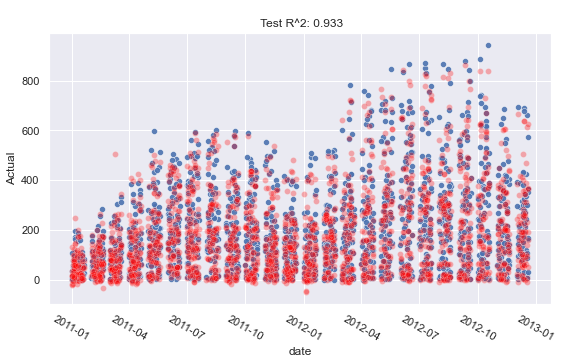

In [40]:
plt.figure(figsize=(9, 5))
sns.set_theme(style="darkgrid")
sns.scatterplot(x="date", y="Actual", data=results, alpha=0.9)
sns.scatterplot(x="date", y='Predicted_polynomial',
                data=results, color="red", alpha=0.3)
plt.xticks(rotation=-30)
plt.title(
    f'\n Test R^2: {np.round(poly_lr.score(X_test_poly,y_test),4)}')
plt.savefig('./output/prediction.png', dpi=300,
            facecolor='white', transparent=False, bbox_inches='tight')


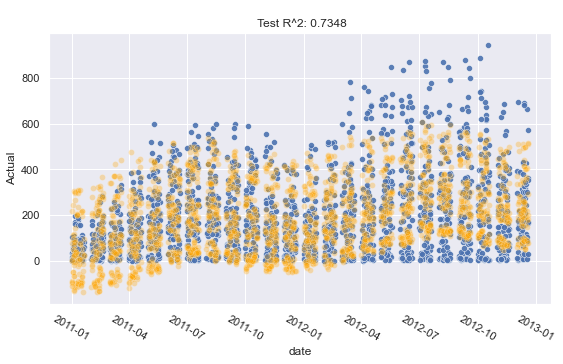

In [41]:
plt.figure(figsize=(9, 5))
sns.set_theme(style="darkgrid")
sns.scatterplot(x="date", y="Actual", data=results, alpha=0.9)
sns.scatterplot(x="date", y="Predicted", data=results, color="orange", alpha=0.3)
plt.xticks(rotation=-30)
plt.title(
    f'\n Test R^2: {np.round(m.score(X_test,y_test),4)}')
plt.savefig('./output/prediction2.png', dpi=300,
            facecolor='white', transparent=False, bbox_inches='tight')


### Distribution of Errors (y_test - y_pred)

In [42]:
error = []
error = pd.DataFrame(error)
error['polynomial'] = (y_test-y_pred_lr_test) 
error['non-polynomial'] = (y_test-y_pred_m_test)
error

,polynomial,non-polynomial
9378,8.651845,-95.669527
4176,14.909528,-1.196733
8438,50.278048,-42.340141
8236,46.767211,2.809272
4754,0.577602,2.491741
...,...,...
2829,16.768503,-52.097349
5012,11.159899,-2.632552
726,-13.027019,-107.241417
10751,75.145390,-59.153549


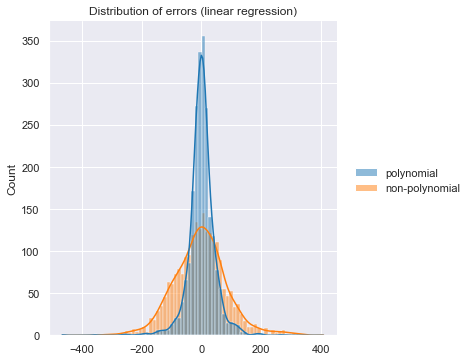

In [43]:
#sns.displot((y_test - y_pred_lr_test), kde=True, bins=50)
sns.displot(error, kde=True, bins=75, alpha=0.5, palette="tab10")
plt.title("Distribution of errors (linear regression)")
plt.savefig('./output/error-distribution.png', dpi=300, bbox_inches='tight')


### Cross-Validation

In [44]:
cv = cross_validate(poly_lr, X_train_poly, y_train,
                       cv=10,
                       scoring='r2',
                       return_train_score=True,
                       )
# convert the dictionary of lists into a DataFrame
cv = pd.DataFrame(cv)
cv = cv[["train_score", "test_score"]]
cv.rename(
    columns={"train_score": "polyn-linr_train",  "test_score": 'polyn-linr_test'}, inplace=True)
cv["test_sets"] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
cv.set_index(["test_sets"], inplace=True)
cv, cv["polyn-linr_train"].mean(), cv["polyn-linr_test"].mean()


(           polyn-linr_train  polyn-linr_test
 test_sets                                   
 1                  0.946125         0.923138
 2                  0.945733         0.928472
 3                  0.945305         0.933164
 4                  0.945870         0.924594
 5                  0.944855         0.935362
 6                  0.945867         0.927880
 7                  0.945455         0.930223
 8                  0.944927         0.935432
 9                  0.945211         0.933425
 10                 0.945828         0.926337,
 0.9455177232925775,
 0.9298027896557086)

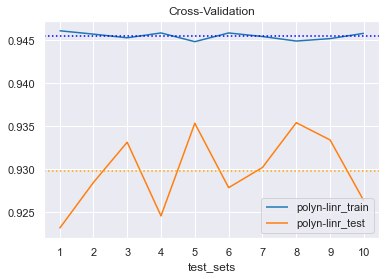

In [45]:
sns.set_theme(style="darkgrid")
sns.lineplot(data=cv, palette="tab10", dashes=[
             (1, 0), (1, 0)])
plt.axhline(y=cv["polyn-linr_train"].mean(),
            color="blue", linestyle="dotted")
plt.axhline(y=cv["polyn-linr_test"].mean(),
            color="orange", linestyle="dotted")
plt.title("Cross-Validation")
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.savefig("./output/cross-validation.png", dpi=300)


In [46]:
scores = cross_val_score(
    poly_lr, X_train_poly, y_train, cv=3, scoring='explained_variance')
print('Average of explained_variance cross-validation scores :', np.average(scores))
scores


Average of explained_variance cross-validation scores : 0.9252950401978507


array([0.92298583, 0.92693642, 0.92596288])